In [82]:
import os
import numpy as np
import copy
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from shapely.geometry import box as Box
from shapely import affinity

import vista
from vista.entities.sensors.camera_utils.ViewSynthesis import DepthModes
from vista.utils import logging
from vista.tasks import MultiAgentBase
from vista.utils import transform

In [83]:
def my_reward_fn(task, agent_id, **kwargs):
    agent = [_a for _a in task.world.agents if _a.id == agent_id][0]
    q_lat = np.abs(agent.relative_state.x)
    road_width = agent.trace.road_width
    z_lat = road_width / 2
    lane_reward = round(1 - (q_lat/z_lat)**2, 4)
    # differential = 0.0 if prev_curvature==0.0 else -np.abs(curvature_action - prev_curvature)
    # reward = (lane_reward + differential) if not kwargs['done'] else torch.tensor(0.0, dtype=torch.float32)
    # if reward < 0:
    #     reward = torch.tensor(0.0, dtype=torch.float32)
    reward = lane_reward
    return reward, {}

2023-07-29 13:48:21,272::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-07-29 13:48:21,437::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-07-29 13:48:21,610::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv
2023-07-29 13:48:21,781::WARNING::[vista.core.Trace._divide_to_good_segments] No video_label.csv


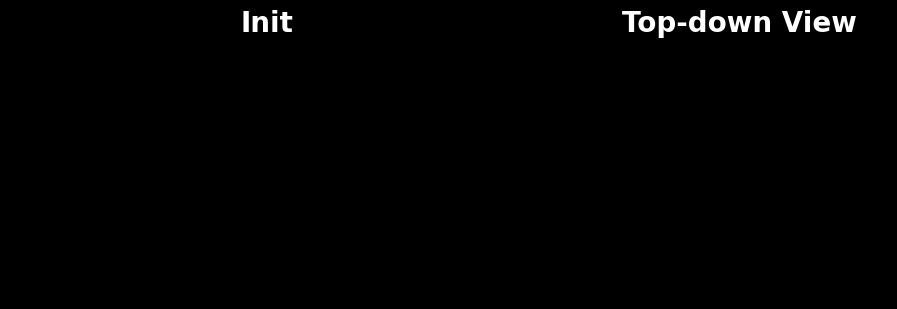

In [84]:
# Initialize the simulator
trace_config = dict(
    road_width=4,
    reset_mode='default',
    master_sensor='camera_front',
)
car_config = dict(
    length=5.,
    width=2.,
    wheel_base=2.78,
    steering_ratio=14.7,
    lookahead_road=True,
)
sensors_config = [
    dict(
        type='camera',
        # camera params
        name='camera_front',
        size=(200, 320),
        # rendering params
        depth_mode=DepthModes.FIXED_PLANE,
        use_lighting=False,
    )
]
task_config = dict(n_agents=2,
                    mesh_dir="../carpack01",
                    init_dist_range=[15., 30.],
                    init_lat_noise_range=[-3., 3.],
                    reward_fn=my_reward_fn)
display_config = dict(road_buffer_size=1000, )

ego_car_config = copy.deepcopy(car_config)
ego_car_config['lookahead_road'] = True
trace_root = "../trace"
trace_path = [
    "20210726-154641_lexus_devens_center", 
    "20210726-155941_lexus_devens_center_reverse", 
    "20210726-184624_lexus_devens_center", 
    "20210726-184956_lexus_devens_center_reverse", 
]
trace_path = [os.path.join(trace_root, p) for p in trace_path]
env = MultiAgentBase(trace_paths=trace_path,
                        trace_config=trace_config,
                        car_configs=[car_config] * task_config['n_agents'],
                        sensors_configs=[sensors_config] + [[]] *
                        (task_config['n_agents'] - 1),
                        task_config=task_config)
display = vista.Display(env.world, display_config=display_config)

In [85]:
def generate_human_actions(world):
    actions = dict()
    for agent in world.agents:
        if agent.id != env.ego_agent.id:
            actions[agent.id] = np.array([0.0,0.0])
        else:
            # Sample a random curvature (between +/- 1/3), keep speed constant
            curvature = np.random.uniform(-1/5, 1/5)
            actions[agent.id] = np.array([curvature, agent.trace.f_speed(agent.timestamp)])
    return actions

In [143]:
# start env
env.reset();
display.reset()  # reset should be called after env reset
print(f"Ego agent id: {env.ego_agent.id}")

Ego agent id: 1d559c


In [152]:
agent = [_a for _a in env.world.agents if _a.id == "1d559c"][0]
print(agent.ego_dynamics)
x = agent.ego_dynamics.x
y = agent.ego_dynamics.y
yaw = x = agent.ego_dynamics.yaw
steering = agent.ego_dynamics.steering
speed = agent.ego_dynamics.speed
steering_bound = agent.ego_dynamics.steering_bound
speed_bound = agent.ego_dynamics.speed_bound
wheel_base = agent.wheel_base
x, y, yaw, steering, speed, steering_bound, speed_bound, wheel_base

<StateDynamics: [0.0, 0.0, 0.0, -0.0764628250030325, 9.924124165183352]>


(0.0,
 0.0,
 0.0,
 -0.0764628250030325,
 9.924124165183352,
 [-0.75, 0.75],
 [0.0, 15.0],
 2.78)

In [149]:
steering_velocity = 0.0
acceleration = 0.0
# Define dynamics
def _ode_func(t, z):
    _x, _y, _phi, _delta, _v = z
    u_delta = steering_velocity
    u_a = acceleration
    new_z = np.array([
        -_v * np.sin(_phi),  # swap x-y axis with sign change
        _v * np.cos(_phi),
        _v / wheel_base * np.tan(_delta),
        u_delta,
        u_a
    ])
    return new_z

In [159]:
dt = 1/30.
# Solve ODE
z_0 = np.array([x, y, yaw, steering, speed])
solver = ode_solve.RK45(_ode_func, 0., z_0, dt)
steps = 0
while solver.status is 'running' and steps <= max_steps:
    solver.step()
    steps += 1

<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_47171/655399030.py:6: SyntaxWarning: "is" with a literal. Did you mean "=="?
  while solver.status is 'running' and steps <= max_steps:


In [168]:
solver.y

array([-0.03227746,  0.99138121, -0.056446  , -0.05540264,  9.92260875])

In [157]:
# follow nominal trajectories for all agents
actions = generate_human_actions(env.world)
# step environment
observations, rewards, dones, infos = env.step(actions)

In [158]:
agent = [_a for _a in env.world.agents if _a.id == "1d559c"][0]
print(agent.ego_dynamics)
x = agent.ego_dynamics.x
y = agent.ego_dynamics.y
yaw = x = agent.ego_dynamics.yaw
steering = agent.ego_dynamics.steering
speed = agent.ego_dynamics.speed
steering_bound = agent.ego_dynamics.steering_bound
speed_bound = agent.ego_dynamics.speed_bound
wheel_base = agent.wheel_base
x, y, yaw, steering, speed, steering_bound, speed_bound, wheel_base

<StateDynamics: [0.022558484113842155, 0.661095199040028, 0.661095199040028, -0.05540263508097742, 9.922608745999334]>


(-0.04984766075982372,
 0.661095199040028,
 -0.04984766075982372,
 -0.05540263508097742,
 9.922608745999334,
 [-0.75, 0.75],
 [0.0, 15.0],
 2.78)

In [164]:
np.gradient(-0.05540263508097742, 0.03333333333333333)

[]

In [139]:
import numpy as np
from scipy.integrate import RK45
import matplotlib.pyplot as plt

# Define the function that computes the first derivative dy/dt
def f(t, y):
    return -2 * y

# Initial conditions for y
t0 = 0.0   # Initial time
y0 = np.array([1.0])   # Initial value of y as a one-dimensional array
t_end = 2.0  # End time for the integration
dt = 1/30.

# Create the RK45 solver object for y
rk45_solver_y = RK45(fun=f, t0=t0, y0=y0, t_bound=2.0)

# Lists to store the solutions
time_points = [t0]
solution_y = [y0[0]]

steps = 0
max_steps = 100
# Perform the integration using the solver
while rk45_solver_y.status == 'running' and steps <= max_steps:
    # Proceed to the next step using the integrate method
    rk45_solver_y.step()
    
    # Store the current time and solution value for y
    time_points.append(rk45_solver_y.t)
    solution_y.append(rk45_solver_y.y[0])
    steps+=1

# Calculate the first derivative dy/dt using the results of y
dy_dt = np.gradient(solution_y, np.gradient(time_points))

# Calculate the second derivative d^2y/dt^2 using the results of dy/dt
second_derivative = np.gradient(dy_dt, np.gradient(time_points))

In [140]:
dy_dt

array([-7.24676019e-01, -1.83337742e+00,  1.77364585e+01, -9.11065192e+01,
       -8.27341335e+01,  1.36008082e-01,  4.06148162e-02])

In [141]:
second_derivative

array([-5.71160040e+00,  5.31445000e+01,  9.61356877e+03,  8.24466927e+03,
        8.36605860e+03, -2.78412127e+02,  6.40897117e-01])

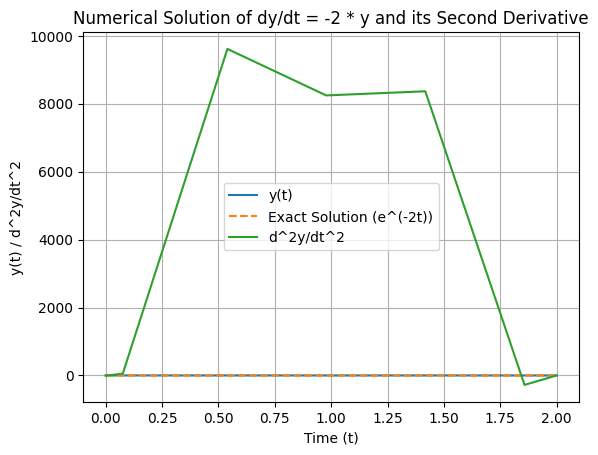

In [142]:
# Plot the results
exact_solution_y = np.exp(-2 * np.array(time_points))
plt.plot(time_points, solution_y, label='y(t)')
plt.plot(time_points, exact_solution_y, label='Exact Solution (e^(-2t))', linestyle='dashed')
plt.plot(time_points, second_derivative, label='d^2y/dt^2')
plt.xlabel('Time (t)')
plt.ylabel('y(t) / d^2y/dt^2')
plt.title('Numerical Solution of dy/dt = -2 * y and its Second Derivative')
plt.legend()
plt.grid(True)
plt.show()

In [123]:
import scipy.integrate as ode_solve
max_steps = 100
# Solve ODE
dt = 1/3
z_0 = np.array([yaw, speed, wheel_base])
solver = ode_solve.RK45(rot_function, 0., z_0, dt)
steps = 0
while solver.status is 'running' and steps <= max_steps:
    solver.step()
    steps += 1

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/w0/3ttb6cs14rq8l4ggd5r1v9440000gn/T/ipykernel_47171/2860661188.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  while solver.status is 'running' and steps <= max_steps:


In [124]:
solver.y

array([ 0.       , 12.1099706,  2.78     ])

In [149]:
done = False
while not done:
    # follow nominal trajectories for all agents
    actions = generate_human_actions(env.world)

    # step environment
    observations, rewards, dones, infos = env.step(actions)
    print(rewards)

    img = display.render()
    cv2.imshow("test", img[:, :, ::-1])
    key = cv2.waitKey(20)
    plt.pause(.05)
    if key == ord('q'):
        break

{'5ff121': 1.0, '4be50c': 0.523}
{'5ff121': 0.9998, '4be50c': 0.523}
{'5ff121': 0.9993, '4be50c': 0.523}
{'5ff121': 0.9988, '4be50c': 0.523}
{'5ff121': 0.998, '4be50c': 0.523}
{'5ff121': 0.9971, '4be50c': 0.523}
{'5ff121': 0.9958, '4be50c': 0.523}
{'5ff121': 0.9944, '4be50c': 0.523}
{'5ff121': 0.9931, '4be50c': 0.523}
{'5ff121': 0.9909, '4be50c': 0.523}
{'5ff121': 0.9863, '4be50c': 0.523}
{'5ff121': 0.979, '4be50c': 0.523}
{'5ff121': 0.9689, '4be50c': 0.523}
{'5ff121': 0.9566, '4be50c': 0.523}
{'5ff121': 0.9419, '4be50c': 0.523}
{'5ff121': 0.9252, '4be50c': 0.523}
{'5ff121': 0.9079, '4be50c': 0.523}
{'5ff121': 0.8923, '4be50c': 0.523}
{'5ff121': 0.8812, '4be50c': 0.523}
{'5ff121': 0.8682, '4be50c': 0.523}
{'5ff121': 0.847, '4be50c': 0.523}
{'5ff121': 0.8194, '4be50c': 0.523}
{'5ff121': 0.7944, '4be50c': 0.523}
{'5ff121': 0.7715, '4be50c': 0.523}
{'5ff121': 0.7431, '4be50c': 0.523}
{'5ff121': 0.7089, '4be50c': 0.523}
{'5ff121': 0.6746, '4be50c': 0.523}
{'5ff121': 0.6425, '4be50c': 0.523

In [2]:
# Define dynamics
def _ode_func(t, z):
    _x, _y, _phi, _delta, _v = z
    u_delta = steering_velocity
    u_a = acceleration
    new_z = np.array([
        -_v * np.sin(_phi),  # swap x-y axis with sign change
        _v * np.cos(_phi),
        _v / self._wheel_base * np.tan(_delta),
        u_delta,
        u_a
    ])
    return new_z

In [ ]:
# Solve ODE
z_0 = np.array(
    [self._x, self._y, self._yaw, self._steering, self._speed])
solver = ode_solve.RK45(_ode_func, 0., z_0, dt)
steps = 0